# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


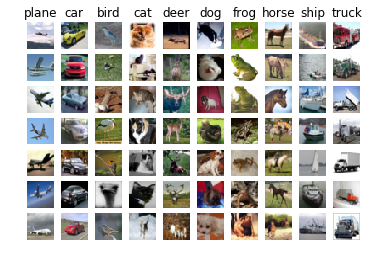

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


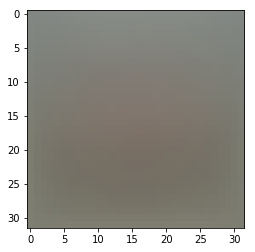

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.830224


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 15.046875 analytic: 15.046875, relative error: 3.521636e-12
numerical: 2.630073 analytic: 2.630073, relative error: 1.634287e-10
numerical: 16.226744 analytic: 16.226744, relative error: 2.513267e-11
numerical: 16.966716 analytic: 16.966716, relative error: 1.086258e-11
numerical: 4.179843 analytic: 4.179843, relative error: 2.292999e-11
numerical: -8.528202 analytic: -8.528202, relative error: 3.859569e-11
numerical: -0.818561 analytic: -0.818561, relative error: 2.026582e-10
numerical: -2.753757 analytic: -2.753757, relative error: 1.869223e-10
numerical: 12.255414 analytic: 12.255414, relative error: 1.749555e-12
numerical: 6.629246 analytic: 6.629246, relative error: 1.666629e-11
numerical: 25.069975 analytic: 25.084245, relative error: 2.845104e-04
numerical: -15.193039 analytic: -15.198792, relative error: 1.892977e-04
numerical: 9.035067 analytic: 9.032734, relative error: 1.291152e-04
numerical: 3.707358 analytic: 3.702397, relative error: 6.695321e-04
numerical: -2.

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.830224e+00 computed in 0.510976s
Vectorized loss: 8.830224e+00 computed in 0.039678s
difference: -0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.300991s
Vectorized loss and gradient: computed in 0.024682s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 793.070758
iteration 100 / 1500: loss 779.882411
iteration 200 / 1500: loss 776.611813
iteration 300 / 1500: loss 772.411204
iteration 400 / 1500: loss 771.327225
iteration 500 / 1500: loss 769.001473
iteration 600 / 1500: loss 764.702916
iteration 700 / 1500: loss 763.197078
iteration 800 / 1500: loss 761.602681
iteration 900 / 1500: loss 759.711532
iteration 1000 / 1500: loss 757.065066
iteration 1100 / 1500: loss 756.334037
iteration 1200 / 1500: loss 754.845589
iteration 1300 / 1500: loss 752.991875
iteration 1400 / 1500: loss 751.613567
That took 23.521291s


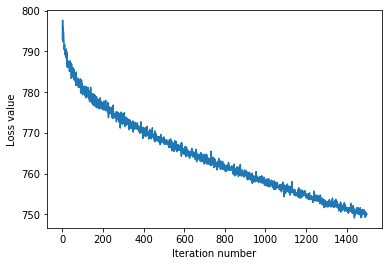

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.302143
validation accuracy: 0.318000


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.

# learning_rates = [1e-7, 3e-7, 1e-6, 3e-6, 1e-5, 5e-5]
# regularization_strengths = [5.5e3, 1.0e4, 2.5e4, 5.5e4, 1.5e5]
learning_rates = [6e-7, 7e-7, 8e-7, 9e-7, 10e-7]
regularization_strengths = [6e4, 7e4, 8e4, 9e4, 10e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################


for l in learning_rates:
    for r in regularization_strengths:
        svm = LinearSVM()    
        loss_hist = svm.train(X_train, y_train, learning_rate=l, reg=r,
                      batch_size=256, num_iters=15000, verbose=True)
        y_train_pred = svm.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(l, r)] = training_accuracy, validation_accuracy
        if (validation_accuracy > best_val):
            best_val = validation_accuracy
            best_svm = svm



################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 15000: loss 1874.075290
iteration 100 / 15000: loss 1822.840629
iteration 200 / 15000: loss 1799.207058
iteration 300 / 15000: loss 1777.830163
iteration 400 / 15000: loss 1761.210743
iteration 500 / 15000: loss 1745.584362
iteration 600 / 15000: loss 1733.373391
iteration 700 / 15000: loss 1722.309087
iteration 800 / 15000: loss 1711.109985
iteration 900 / 15000: loss 1699.923568
iteration 1000 / 15000: loss 1689.696923
iteration 1100 / 15000: loss 1680.431177
iteration 1200 / 15000: loss 1671.683605
iteration 1300 / 15000: loss 1663.257235
iteration 1400 / 15000: loss 1656.679821
iteration 1500 / 15000: loss 1649.690557
iteration 1600 / 15000: loss 1642.856725
iteration 1700 / 15000: loss 1636.590228
iteration 1800 / 15000: loss 1630.812816
iteration 1900 / 15000: loss 1624.831319
iteration 2000 / 15000: loss 1619.848237
iteration 2100 / 15000: loss 1613.431805
iteration 2200 / 15000: loss 1608.413750
iteration 2300 / 15000: loss 1603.479877
iteration 2400 / 15000: loss

iteration 5000 / 15000: loss 1753.467156
iteration 5100 / 15000: loss 1751.947757
iteration 5200 / 15000: loss 1749.429380
iteration 5300 / 15000: loss 1747.971783
iteration 5400 / 15000: loss 1746.187247
iteration 5500 / 15000: loss 1744.562092
iteration 5600 / 15000: loss 1743.210887
iteration 5700 / 15000: loss 1741.317148
iteration 5800 / 15000: loss 1739.705777
iteration 5900 / 15000: loss 1738.052561
iteration 6000 / 15000: loss 1737.027161
iteration 6100 / 15000: loss 1735.911414
iteration 6200 / 15000: loss 1734.009902
iteration 6300 / 15000: loss 1732.975008
iteration 6400 / 15000: loss 1732.166935
iteration 6500 / 15000: loss 1729.667426
iteration 6600 / 15000: loss 1729.417661
iteration 6700 / 15000: loss 1727.938554
iteration 6800 / 15000: loss 1727.456804
iteration 6900 / 15000: loss 1725.532318
iteration 7000 / 15000: loss 1724.520499
iteration 7100 / 15000: loss 1723.232311
iteration 7200 / 15000: loss 1722.710254
iteration 7300 / 15000: loss 1721.726432
iteration 7400 /

iteration 9900 / 15000: loss 1995.654611
iteration 10000 / 15000: loss 1995.247059
iteration 10100 / 15000: loss 1995.108891
iteration 10200 / 15000: loss 1994.352418
iteration 10300 / 15000: loss 1994.686636
iteration 10400 / 15000: loss 1994.009925
iteration 10500 / 15000: loss 1994.312711
iteration 10600 / 15000: loss 1993.442340
iteration 10700 / 15000: loss 1993.908992
iteration 10800 / 15000: loss 1993.611778
iteration 10900 / 15000: loss 1993.053336
iteration 11000 / 15000: loss 1992.787061
iteration 11100 / 15000: loss 1993.566377
iteration 11200 / 15000: loss 1992.615181
iteration 11300 / 15000: loss 1992.866243
iteration 11400 / 15000: loss 1992.111645
iteration 11500 / 15000: loss 1992.772920
iteration 11600 / 15000: loss 1992.310029
iteration 11700 / 15000: loss 1992.884865
iteration 11800 / 15000: loss 1992.590081
iteration 11900 / 15000: loss 1992.752697
iteration 12000 / 15000: loss 1992.928871
iteration 12100 / 15000: loss 1993.091054
iteration 12200 / 15000: loss 1992.

iteration 14700 / 15000: loss 2175.304601
iteration 14800 / 15000: loss 2175.997538
iteration 14900 / 15000: loss 2176.028207
iteration 0 / 15000: loss 3075.024365
iteration 100 / 15000: loss 3001.173760
iteration 200 / 15000: loss 2960.638079
iteration 300 / 15000: loss 2927.424421
iteration 400 / 15000: loss 2899.194814
iteration 500 / 15000: loss 2874.000109
iteration 600 / 15000: loss 2850.245824
iteration 700 / 15000: loss 2829.386850
iteration 800 / 15000: loss 2809.831620
iteration 900 / 15000: loss 2792.568436
iteration 1000 / 15000: loss 2776.828470
iteration 1100 / 15000: loss 2761.502007
iteration 1200 / 15000: loss 2746.718050
iteration 1300 / 15000: loss 2733.730180
iteration 1400 / 15000: loss 2720.834078
iteration 1500 / 15000: loss 2708.750372
iteration 1600 / 15000: loss 2698.394202
iteration 1700 / 15000: loss 2686.920642
iteration 1800 / 15000: loss 2677.700971
iteration 1900 / 15000: loss 2667.191885
iteration 2000 / 15000: loss 2658.477650
iteration 2100 / 15000: l

In [ ]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*